In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
functions_path = '/content/gdrive/MyDrive/Project/functions.py'
negative_path = '/content/gdrive/MyDrive/Project/negative.csv'
positive_path = '/content/gdrive/MyDrive/Project/positive.csv'

In [ ]:
with open("functions.py", 'w') as fw:
    with open(functions_path, 'r') as f:
        for l in f:
            fw.write(l)

# Imports

In [ ]:
pip install pymorphy2

In [ ]:
from functions import *
from gensim import corpora, models, similarities
from gensim.models import Word2Vec
from matplotlib import pyplot as plt
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from spacy.lang.ru import Russian
from tqdm import tqdm
from torchvision import transforms


import collections
import copy
import gensim
import lightgbm as lgb
import math
import nltk
import numpy as np
import pandas as pd
import random
import re
import seaborn as sn
import spacy
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import xgboost

# Preprocessing Data

База данных состоит из 12 столбцов:

– id: уникальный номер сообщения в системе twitter;

– tdate: дата публикации сообщения (твита);

– tnamee: имя пользователя, опубликовавшего сообщение;

– ttext:  текст сообщения (твита);

– ttype: поле в котором в дальнейшем будет указано к кому классу относится твит (положительный, отрицательный, нейтральный);

– trep: количество реплаев к данному сообщению. В настоящий момент API твиттера не отдает эту информацию;

– trtw: число ретвитов;

– tfav: число сколько раз данное сообщение было добавлено в избранное другими пользователями;

– tstcount: число всех сообщений пользователя в сети twitter;

– tfol: количество фоловеров пользователя (тех людей, которые читают пользователя);

– tfrien: количество друзей пользователя (те люди, которых читает пользователь);

– listcount: количество листов-подписок в которые добавлен твиттер-пользователь.

Прочитаем данные и построим различные статистики.

In [ ]:
columns_name = ['id', 'tdate', 'tname', 'ttext', 'ttype', 'trep','trtw', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount']
positive_dataset = pd.read_csv('positive.csv', sep = ';', names = columns_name)
negative_dataset = pd.read_csv('negative.csv', sep = ';', names = columns_name)

In [ ]:
len(positive_dataset)

114911

In [ ]:
positive_dataset.head()

,id,tdate,tname,ttext,ttype,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


Тренировочный корпус состоит из 114,911 положительных, 111,923 отрицательных записей.

Удалим NA.

In [ ]:
pos_text = positive_dataset['ttext'].dropna().values
neg_text = negative_dataset['ttext'].dropna().values

In [ ]:
#отделим от слов смайлики и запишем их как один
def split_smile(r,smile, t):
  ans = []
  for i in t:
    ans.append(re.sub(r,smile, i))
  return ans   

In [ ]:
pos_text = regul(r' *http\S* *', pos_text)
pos_text = regul(r' *@\S* ', pos_text)
pos_text = regul(r'RT *', pos_text)
pos_text = regul(r'&quot;', pos_text)
pos_text = regul(r'\n', pos_text)
pos_text = regul(r'[.,!?#$%&0-9A-Za-z&\"\']+', pos_text)
pos_text = split_smile(r'(\w)([:;/\!]*)\)+', r'\1 \2)', pos_text)
# pos_text = split_smile(r'(\w)\)+', r'\1 )', pos_text)

In [ ]:
pos_text[10]

'Люблю маму и папу а в остальное я так -влюбляюсь  привязываюсь )\xa0'

In [ ]:
neg_text = regul(r' *http\S* *', neg_text)
neg_text = regul(r' *@\S* ', neg_text)
neg_text = regul(r'RT *', neg_text)
neg_text = regul(r'&quot;', neg_text)
neg_text = regul(r'\n', neg_text)
neg_text = regul(r'[.,!?#$%&0-9A-Za-z&\"\']+', neg_text)
neg_text = split_smile(r'(\w)([:/\!]*)\(+', r'\1 \2(', neg_text)
# neg_text = split_smile(r'(\w)\(+', r'\1 (', neg_text)

In [ ]:
len_pos = len(pos_text)
len_neg = len(neg_text)

In [ ]:
twits = np.concatenate((pos_text, neg_text))
twits

array([' хоть я и школота  но поверь  у нас то же самое :  общество профилирующий предмет типа )',
       'Да  все-таки он немного похож на него  Но мой мальчик все равно лучше: ',
       ' Ну ты идиотка ) я испугалась за тебя ', ...,
       'Вот и в школу  в говно это идти уже надо (',
       ' Тауриэль  не грусти :( *обнял*',
       'Такси везет меня на работу  Раздумываю приплатить  чтобы меня втащили на пятый этаж  Лифта то нет :('],
      dtype='<U159')

In [ ]:
labels = [1] * len_pos + [0] * len_neg
labels = np.array(labels)
labels

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
symb_len = [len(i) for i in twits]
word_len = [len(i.split()) for i in twits]

Найдем среднее, медиану, стандартное отклонение, минимальное, максимальное значение.

In [ ]:
symb_mean = np.mean(symb_len)
word_mean = np.mean(word_len)
print(symb_mean, word_mean)

68.30129522029326 12.097890968726029


In [ ]:
symb_median = np.median(symb_len)
word_median = np.median(word_len)
print(symb_median, word_median)

63.0 11.0


In [ ]:
symb_std = np.std(symb_len)
word_std = np.std(word_len)
print(symb_std, word_std)

29.106003039930123 5.152044015732866


In [ ]:
symb_min = np.min(symb_len)
word_min = np.min(word_len)
symb_max = np.max(symb_len)
word_max = np.max(word_len)
print(symb_min, word_min, symb_max, word_max)

2 1 159 36


Построим гистограммы

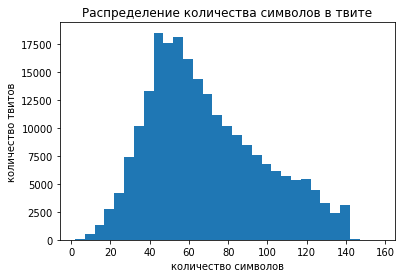

In [ ]:
create_hist(symb_len, np.arange(symb_min, symb_max, 5), 'Распределение количества символов в твите', 'количество символов', 'количество твитов')

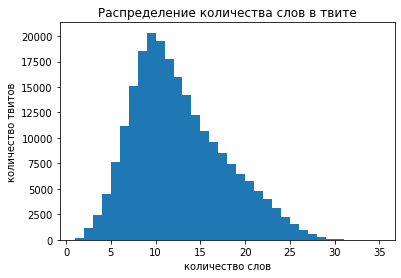

In [ ]:
create_hist(word_len, np.arange(word_min, word_max, 1), 'Распределение количества слов в твите', 'количество слов', 'количество твитов')

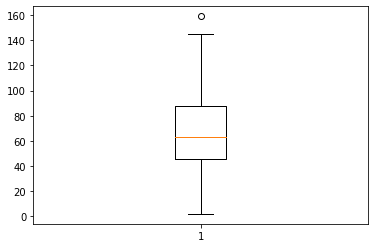

In [ ]:
create_boxplot(symb_len)

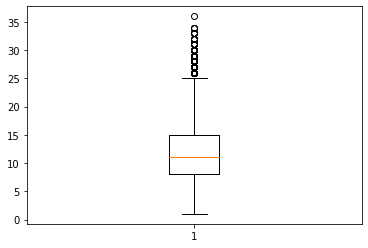

In [ ]:
create_boxplot(word_len)

In [ ]:
get_ngrams(2, twits, worst=True)

Лучшие 10 2-грамм
[(('у', 'меня'), 8268), (('я', 'не'), 4470), (('а', 'я'), 3705), (('и', 'не'), 3235), (('что', 'я'), 2862), (('не', 'могу'), 2804), (('у', 'нас'), 2318), (('не', 'знаю'), 1992), (('у', 'тебя'), 1601), (('и', 'я'), 1520)]
Худшие 10 2-грамм
[(('Лифта', 'то'), 1), (('этаж', 'Лифта'), 1), (('пятый', 'этаж'), 1), (('на', 'пятый'), 1), (('втащили', 'на'), 1), (('меня', 'втащили'), 1), (('приплатить', 'чтобы'), 1), (('Раздумываю', 'приплатить'), 1), (('работу', 'Раздумываю'), 1), (('Такси', 'везет'), 1)]


In [ ]:
get_frequent_words(' '.join(twits), top=10)

[('не', 69370),
 (')', 65535),
 ('и', 55018),
 ('(', 54483),
 ('в', 52888),
 ('я', 52550),
 ('на', 35716),
 ('что', 31491),
 ('а', 26709),
 ('с', 25512)]

# Training of the first sentiment model

Algorithm:

- creating of word2vec
- training model: one of the GBM (i.e. LightGBM, XGBoost) / SVM / ...)

Разобьем данные на train/test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(twits, labels, test_size=0.2, random_state=42)

In [ ]:
X_train

array(['Немного выпьем  говорил он  ничего не будет  говорил он )',
       'я по твоему общению и шуткам соскучилась  Че-то давно не виделись (',
       ' ахахаахх как ты мою собаку уже не называл  ))', ...,
       'дому чуть больше   лет а мне приходится вторую раковину менять ;(',
       '  даже представить боюсь (',
       'через   дней будет месяц как мы не общаемся  мм да уж как время быстро летит ('],
      dtype='<U159')

In [ ]:
def tokenize(X):
    X_ans = []
    for el in X:
        X_ans.append(el.strip().split()) 
    return X_ans    

In [ ]:
#c каждого предложения получим список слов
X_right = tokenize(X_train)    

In [ ]:
# def lemmatize(l):
#     morph = MorphAnalyzer()
#     ans_tw = []
#     for twit in tqdm(l):
#       ans = []
#       for word in twit:
#           ans.append(morph.normal_forms(word))
#       ans_tw.append(ans)
#     return ans_tw     

In [ ]:
# X_right = lemmatize(X_right)

100%|██████████| 181467/181467 [09:23<00:00, 321.80it/s]


In [ ]:
X_right[:5]

[['Немного',
  'выпьем',
  'говорил',
  'он',
  'ничего',
  'не',
  'будет',
  'говорил',
  'он',
  ')'],
 ['я',
  'по',
  'твоему',
  'общению',
  'и',
  'шуткам',
  'соскучилась',
  'Че-то',
  'давно',
  'не',
  'виделись',
  '('],
 ['ахахаахх', 'как', 'ты', 'мою', 'собаку', 'уже', 'не', 'называл', '))'],
 ['лично',
  'мне',
  'было',
  'вообще',
  'по',
  'барабану',
  'на',
  'гиа',
  'и',
  'я',
  'написала',
  'на',
  '5',
  '4',
  '4',
  '4',
  'так',
  'что',
  'не',
  'заморачивайтесь',
  'можно',
  'списать',
  'спокойно',
  ':'],
 ['Наташа',
  'реальный',
  'китаец',
  'пишет',
  'что',
  'не',
  'хера',
  'не',
  'понять',
  '))))']]

In [ ]:
model_right = gensim.models.Word2Vec(X_right, min_count = 1, window = 10,  sg = 1)

In [ ]:
model_right.wv.most_similar('уроке', topn=10)

[('уроках', 0.917378842830658),
 ('физ-ре', 0.9041421413421631),
 ('самостоятельную', 0.8923436999320984),
 ('контрольную', 0.88353431224823),
 ('перемене', 0.8742630481719971),
 ('парте', 0.8727004528045654),
 ('укр', 0.8692817687988281),
 ('столовой', 0.8676010370254517),
 ('географии', 0.8640938401222229),
 ('биологии', 0.862708330154419)]

In [ ]:
model_right.wv['улице']

array([ 0.00596978, -0.67614526, -0.02648533,  0.3647519 , -0.10840542,
        1.3563868 , -0.22717278,  0.27599502, -0.77107096, -0.074504  ,
       -0.04219999,  0.85818285, -0.1805009 ,  0.13772899, -1.2244619 ,
        0.26392666,  0.7816838 , -0.32925448, -0.89375335, -0.10780422,
        0.26722103, -0.48165312,  0.9979126 ,  0.09572151,  0.047401  ,
       -0.10841226, -1.1170268 , -0.15168943,  0.5896169 ,  0.0253674 ,
        0.3017865 ,  0.10214067,  0.25122207,  0.33183712,  0.73832834,
       -0.07553694, -0.04542083,  0.10247461,  0.4308253 , -0.08292812,
        0.6691749 ,  0.37016296, -0.16467878, -0.436692  , -0.43836796,
        0.05876644, -0.69570905, -0.10514926,  0.77584845, -0.21623337,
        0.2871829 ,  0.13949399, -0.15227559,  0.4592346 ,  0.2777108 ,
        0.01583131, -0.38656068,  0.07019323,  0.5468437 ,  0.9118321 ,
       -0.25100538, -0.9396516 ,  0.12689227,  0.02859373, -0.2587734 ,
       -0.19397381,  0.15918699, -0.74988705, -0.59395427,  0.00

In [ ]:
def find_mean_vec(X, model):
    X_ans = []
    for i in range(len(X)):
        ans = 0
        for j in range(len(X[i])):
            ans += model.wv[X[i][j]]
        X_ans.append(ans/len(X[i])) 
    return X_ans        

In [ ]:
# посчитаем среднее значение векторов, входящих в твит
X_vec = find_mean_vec(X_right, model_right)

## XGBoost

In [ ]:
model = xgboost.XGBClassifier(n_estimators=200)
model.fit(np.array(X_vec), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
X_right_test = tokenize(X_test)

Обучим модель w2v также на тестовом датасете.

In [ ]:
model_right.train(X_right_test, total_examples = len(X_right_test), epochs = 10)

(4241310, 5482800)

In [ ]:
model_right.build_vocab(X_right_test, update=True)

In [ ]:
X_vec_test = find_mean_vec(X_right_test, model_right)

In [ ]:
y_pred = model.predict(np.array(X_vec_test))
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# 76.70% с /len(X_right_test[i]) с ! 
# 69.93% без /len(X_right_test[i])
# 77.43% с /len(X_right_test[i]) и без !
# 80.04%
# 86.12%
# 85.54%
# 86.79%
# 88.59%
# 90.26%

Accuracy: 90.26%


0.9662589551062182


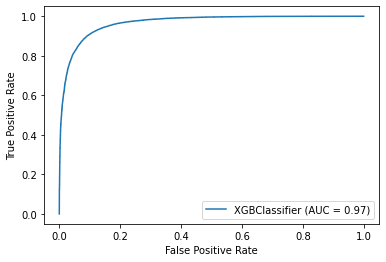

In [ ]:
y_score = model.predict_proba(X_vec_test)
print(roc_auc_score(y_test, y_score[:, 1]))

metrics.plot_roc_curve(model, X_vec_test, y_test)  
plt.show()                               

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90     22480
           1       0.92      0.89      0.90     22887

    accuracy                           0.90     45367
   macro avg       0.90      0.90      0.90     45367
weighted avg       0.90      0.90      0.90     45367



In [ ]:
conf_m = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print(conf_m)

Predicted      0      1
Actual                 
0          20598   1882
1           2537  20350


## LIGHTGBM


In [ ]:
clf = lgb.LGBMClassifier(learning_rate=0.1)
clf.fit(X_vec, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred=clf.predict(X_vec_test)

In [ ]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
# 0.7822
# 0.7708
# 0.8611

LightGBM Model accuracy score: 0.9013


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90     22480
           1       0.91      0.90      0.90     22887

    accuracy                           0.90     45367
   macro avg       0.90      0.90      0.90     45367
weighted avg       0.90      0.90      0.90     45367



0.9650717669916892


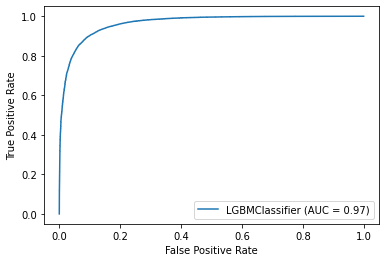

In [ ]:
y_score = clf.predict_proba(X_vec_test)
print(roc_auc_score(y_test, y_score[:, 1]))

metrics.plot_roc_curve(clf, X_vec_test, y_test)  
plt.show()  

## Random Forest

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=42, n_estimators = 200)
clf.fit(X_vec, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = clf.predict(X_vec_test)

In [ ]:
# accuracy=accuracy_score(y_pred, y_test)
print('Random forest Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Random forest Model accuracy score: 0.8189


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     22480
           1       0.82      0.83      0.82     22887

    accuracy                           0.82     45367
   macro avg       0.82      0.82      0.82     45367
weighted avg       0.82      0.82      0.82     45367



## Простая нейронная сеть

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return torch.sigmoid(x)

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)


In [ ]:
y_train_new = [np.eye(2)[i] for i in y_train]
y_test_new = [np.eye(2)[i] for i in y_test]

In [ ]:
X_train_net = torch.Tensor(X_vec)
y_train_net = torch.Tensor(y_train_new)

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [ ]:
BATCH_SIZE = 128
EPOCHS = 30

for epoch in tqdm(range(EPOCHS)):
    random_index = np.random.permutation(len(X_train_net))
    X_train_net = X_train_net[random_index]
    y_train_net = y_train_net[random_index]

    for i in range(0, len(X_train_net), BATCH_SIZE): 

        batch_X = X_train_net[i:i+BATCH_SIZE]
        batch_y = y_train_net[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    

    print(f"Epoch: {epoch}. Loss: {loss}")

  3%|▎         | 1/30 [00:02<01:07,  2.34s/it]

Epoch: 0. Loss: 0.03761076554656029


  7%|▋         | 2/30 [00:04<01:04,  2.30s/it]

Epoch: 1. Loss: 0.03438318893313408


 10%|█         | 3/30 [00:06<01:01,  2.28s/it]

Epoch: 2. Loss: 0.0367092601954937


 13%|█▎        | 4/30 [00:09<00:58,  2.27s/it]

Epoch: 3. Loss: 0.0438724048435688


 17%|█▋        | 5/30 [00:11<00:56,  2.26s/it]

Epoch: 4. Loss: 0.027101395651698112


 20%|██        | 6/30 [00:13<00:53,  2.25s/it]

Epoch: 5. Loss: 0.04600337892770767


 23%|██▎       | 7/30 [00:15<00:51,  2.25s/it]

Epoch: 6. Loss: 0.034682728350162506


 27%|██▋       | 8/30 [00:17<00:49,  2.25s/it]

Epoch: 7. Loss: 0.032206904143095016


 30%|███       | 9/30 [00:20<00:47,  2.27s/it]

Epoch: 8. Loss: 0.028686020523309708


 33%|███▎      | 10/30 [00:22<00:45,  2.26s/it]

Epoch: 9. Loss: 0.055867720395326614


 37%|███▋      | 11/30 [00:24<00:43,  2.27s/it]

Epoch: 10. Loss: 0.04869672283530235


 40%|████      | 12/30 [00:27<00:40,  2.27s/it]

Epoch: 11. Loss: 0.011771646328270435


 43%|████▎     | 13/30 [00:29<00:38,  2.27s/it]

Epoch: 12. Loss: 0.022225555032491684


 47%|████▋     | 14/30 [00:31<00:36,  2.28s/it]

Epoch: 13. Loss: 0.051518503576517105


 50%|█████     | 15/30 [00:34<00:34,  2.30s/it]

Epoch: 14. Loss: 0.02263723313808441


 53%|█████▎    | 16/30 [00:36<00:32,  2.32s/it]

Epoch: 15. Loss: 0.03657275065779686


 57%|█████▋    | 17/30 [00:38<00:30,  2.34s/it]

Epoch: 16. Loss: 0.02989726886153221


 60%|██████    | 18/30 [00:41<00:28,  2.37s/it]

Epoch: 17. Loss: 0.026271438226103783


 63%|██████▎   | 19/30 [00:43<00:26,  2.38s/it]

Epoch: 18. Loss: 0.023277342319488525


 67%|██████▋   | 20/30 [00:46<00:23,  2.39s/it]

Epoch: 19. Loss: 0.037232331931591034


 70%|███████   | 21/30 [00:48<00:21,  2.42s/it]

Epoch: 20. Loss: 0.018633440136909485


 73%|███████▎  | 22/30 [00:51<00:19,  2.46s/it]

Epoch: 21. Loss: 0.019396552816033363


 77%|███████▋  | 23/30 [00:53<00:17,  2.48s/it]

Epoch: 22. Loss: 0.029810408130288124


 80%|████████  | 24/30 [00:56<00:14,  2.49s/it]

Epoch: 23. Loss: 0.03235957399010658


 83%|████████▎ | 25/30 [00:58<00:12,  2.50s/it]

Epoch: 24. Loss: 0.028162719681859016


 87%|████████▋ | 26/30 [01:01<00:10,  2.51s/it]

Epoch: 25. Loss: 0.023167133331298828


 90%|█████████ | 27/30 [01:03<00:07,  2.50s/it]

Epoch: 26. Loss: 0.03163781762123108


 93%|█████████▎| 28/30 [01:06<00:05,  2.51s/it]

Epoch: 27. Loss: 0.026846662163734436


 97%|█████████▋| 29/30 [01:08<00:02,  2.52s/it]

Epoch: 28. Loss: 0.012242784723639488


100%|██████████| 30/30 [01:11<00:00,  2.38s/it]

Epoch: 29. Loss: 0.011086716316640377


In [ ]:
X_test_net = torch.Tensor(X_vec_test)
y_test_net = torch.Tensor(y_test_new)

In [ ]:
correct = 0
total = 0
vect_y_predict = []
with torch.no_grad():
    for i in tqdm(range(len(X_test_net))):
        real_class = torch.argmax(y_test_net[i])
        net_out = net(X_test_net[i]) 
        predicted_class = torch.argmax(net_out)
        vect_y_predict.append(predicted_class.item())
        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))
# 0.891
# 0.907
# 0.917

100%|██████████| 45367/45367 [00:05<00:00, 8020.75it/s]

Accuracy:  0.917


In [ ]:
print(classification_report(y_test,vect_y_predict))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     22480
           1       0.95      0.88      0.92     22887

    accuracy                           0.92     45367
   macro avg       0.92      0.92      0.92     45367
weighted avg       0.92      0.92      0.92     45367



# Extension of word2vec

Algorithm:

- Train TF-IDF model on the normalized corpus
- TF = frequency of a word in document, IDF = log(N/#{count of documents with a word})
- word2vec.get_vector(word) * idf(word) 

In [ ]:
def compute_tf(text):
    tf_text = collections.Counter(text)
    for i in tf_text:
        tf_text[i] = tf_text[i]/float(len(text))
    return tf_text  

In [ ]:
def compute_idf(word, corpus):
    s = sum([1.0 for i in corpus if word in i])
    if s == 0:
        return math.log10(len(corpus))
    return math.log2(len(corpus)/s)

In [ ]:
dictionary = corpora.Dictionary(X_right)
corpus = [dictionary.doc2bow(text) for text in X_right]
tfidf = models.TfidfModel(corpus)

In [ ]:
dictionary.token2id['мой']

243

In [ ]:
tfidf.idfs[dictionary.token2id['мой']]

6.444900566578848

In [ ]:
tfidf.idfs[dictionary.token2id[':)']]

3.5928307440544955

In [ ]:
#сделать функцию для test и train
X_vec_idf = []
for i in tqdm(range(len(X_right))):
    ans = 0
    for el in X_right[i]:
        ans += model_right.wv[el] * tfidf.idfs[dictionary.token2id[el]]
                                                    
    X_vec_idf.append(ans)

100%|██████████| 181467/181467 [00:15<00:00, 11778.31it/s]


Обучим модель

In [ ]:
model_2 = xgboost.XGBClassifier()
model_2.fit(np.array(X_vec_idf), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
X_vec_idf_test = []
for i in tqdm(range(len(X_right_test))):
    ans = 0
    for el in X_right_test[i]:
        if el in dictionary:
          idf = tfidf.idfs[dictionary.token2id[el]]
        else:
          idf = np.sqrt(len(X_right))  

        ans += model_right.wv[el] * idf
                                                    
    X_vec_idf_test.append(ans)

100%|██████████| 45367/45367 [00:05<00:00, 7952.07it/s]


In [ ]:
y_pred = model_2.predict(np.array(X_vec_idf_test))
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
#61.70%
#71.20%
#75.97%
#77.24%

Accuracy: 77.24%


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.86      0.79     22480
           1       0.84      0.68      0.75     22887

    accuracy                           0.77     45367
   macro avg       0.78      0.77      0.77     45367
weighted avg       0.78      0.77      0.77     45367



In [ ]:
def plot_confusion_matrix(labels, pred_labels):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels);
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels = range(10));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

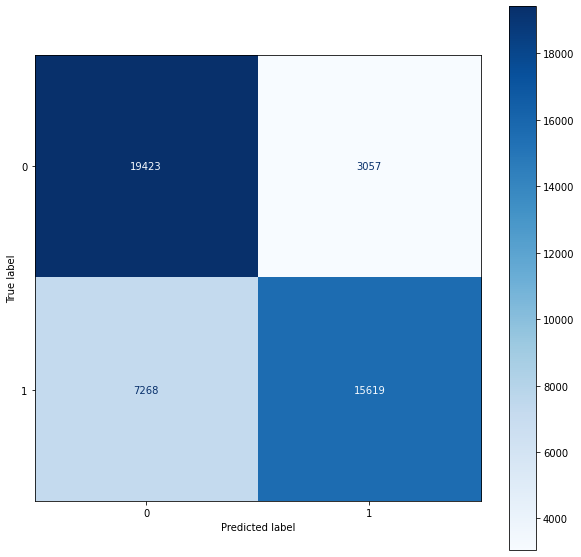

In [ ]:
plot_confusion_matrix(y_test, y_pred)

# Tacatron encoder

Теперь построим нейронную сеть, такую как encoder в Tacatron.

In [ ]:
class Encoder(nn.Module):

    def __init__(self, vocab_size, embedding_size):

        super().__init__()
        self.embedding_size = embedding_size
        self.embed = nn.Embedding(vocab_size, embedding_size)

        self.conv1 = nn.Conv1d(36, 8, 4)
        self.conv2 = nn.Conv1d(8, 16, 4)
        self.conv3 = nn.Conv1d(16, 32, 4)

        self.lstm = nn.LSTM(23, 20, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(32*20*2, 2)


    def forward(self, x):

        x = self.embed(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        packed_output, (hidden, cell) = self.lstm(x)
        cat = packed_output
        rel = F.relu(cat)
        ans = rel.reshape(rel.shape[0], -1)
        dense1 = self.fc1(ans)
      
        return dense1

In [ ]:
len_pos = len(pos_text)
len_neg = len(neg_text)
twits = np.concatenate((pos_text, neg_text))
labels = [1] * len_pos + [0] * len_neg
labels = np.array(labels)

- Фиксируем длину вектора равным максимальному числу слов в твите. То есть каждому твиту сопоставляем числовой вектор такого размера.

- Строим словарь слов (как раньше), но только по твитам из Train.

- Зафиксируем 0 (ноль) – как служебный символ. Будем его использовать, когда слова нет.

- Зафиксируем 1 (единица) – как служебный символ. Будем использовать, если для слова нет кода.

- Теперь можно сделать batch_size = 32.

In [ ]:
#токенизируем
X_twits = tokenize(twits)

In [ ]:
# максимальное число слов в твите
def find_max_number(X_twits):
    max_len = 0
    for i in X_twits:
      if len(i) > max_len:
        max_len = len(i)  
    return max_len    

In [ ]:
max_len = find_max_number(X_twits)
max_len

36

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_twits, labels, test_size=0.2, random_state=42)

In [ ]:
def build_dict(twits_lst, indent=2):
    X_dict = {}
    for twit in twits_lst:
        for w in twit:
            if w not in X_dict:
                word_code = len(X_dict) + indent
                X_dict[w] = word_code

    return X_dict

In [ ]:
X_dict = build_dict(X_train)

In [ ]:
# кодируем слова в соответствии со словарем
def encode(X):
    X_twits_encoded = copy.deepcopy(X)
    for n_el, el in enumerate(X_twits_encoded):
      for n_i, i in enumerate(el):
        if i in X_dict:
          el[n_i] = X_dict[i]   
        else:
          el[n_i] = 1  
    return X_twits_encoded     

In [ ]:
X_train_encoded = encode(X_train)
X_test_encoded = encode(X_test)

In [ ]:
X_test_encoded[0]

[145440, 34, 178, 9772, 114, 10, 3119, 199, 6, 7, 1676, 114]

In [ ]:
# добавляем нули, чтобы дополнить вектор до длины = максимальному числу слов в твите
def addition(X, number_words=max_len):
    X_add = copy.deepcopy(X)
    for i, el in enumerate(X):
        cur_len = len(el)
        add_zero = number_words - cur_len
        cur_list = copy.deepcopy(el)
        cur_list+=[0]*add_zero
        X_add[i] = cur_list

    return X_add     

In [ ]:
X_train_encoded = addition(X_train_encoded)
X_test_encoded = addition(X_test_encoded)

In [ ]:
len(X_test_encoded[0])

36

In [ ]:
vocab_size = len(X_dict) + 2
embedding_size = 32

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
net = Encoder(vocab_size, embedding_size).to(device)

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [ ]:
y_train_new = [np.eye(2)[i] for i in y_train]
y_test_new = [np.eye(2)[i] for i in y_test]

In [ ]:
BATCH_SIZE = 64
EPOCHS = 10

In [ ]:
for epoch in tqdm(range(EPOCHS)):

    for i in range(0, len(X_train_encoded), BATCH_SIZE): 

        batch_X = torch.LongTensor(X_train_encoded[i:i+BATCH_SIZE]).view(min(BATCH_SIZE, len(X_train_encoded[i:i+BATCH_SIZE])), -1)
        batch_y = torch.LongTensor(y_train[i:i+BATCH_SIZE])

        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        net.zero_grad()

        outputs = net(batch_X)
        t = batch_y
        loss = loss_function(outputs, t)
        loss.backward()
        optimizer.step()    

    print(f"Epoch: {epoch}. Loss: {loss}")

 10%|█         | 1/10 [00:33<05:02, 33.58s/it]

Epoch: 0. Loss: 0.18540991842746735


 20%|██        | 2/10 [01:06<04:27, 33.44s/it]

Epoch: 1. Loss: 0.06380697339773178


 30%|███       | 3/10 [01:39<03:52, 33.28s/it]

Epoch: 2. Loss: 0.11360973119735718


 40%|████      | 4/10 [02:12<03:19, 33.28s/it]

Epoch: 3. Loss: 0.23684166371822357


 50%|█████     | 5/10 [02:46<02:46, 33.26s/it]

Epoch: 4. Loss: 0.19196580350399017


 60%|██████    | 6/10 [03:19<02:13, 33.34s/it]

Epoch: 5. Loss: 0.05037352070212364


 70%|███████   | 7/10 [03:52<01:40, 33.35s/it]

Epoch: 6. Loss: 0.05242541432380676


 80%|████████  | 8/10 [04:26<01:06, 33.35s/it]

Epoch: 7. Loss: 0.16980594396591187


 90%|█████████ | 9/10 [04:59<00:33, 33.40s/it]

Epoch: 8. Loss: 0.055393293499946594


100%|██████████| 10/10 [05:33<00:00, 33.34s/it]

Epoch: 9. Loss: 0.061268702149391174


In [ ]:
correct = 0
total = 0
vect_y_predict = []
with torch.no_grad():
    for i in tqdm(range(len(X_test_encoded))):

        batch_X = torch.LongTensor(X_test_encoded[i]).view(1, -1)
        batch_y = torch.LongTensor(y_test[i])
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        net_out = net(batch_X) 
        predicted_class = torch.argmax(net_out)
        vect_y_predict.append(predicted_class.item())

        if predicted_class == y_test[i]:
            correct += 1
        total += 1

print("Accuracy: ", round(correct/total, 3))
#0.919
#0.966

100%|██████████| 45367/45367 [02:01<00:00, 374.87it/s]

Accuracy:  0.966


In [ ]:
print(classification_report(y_test, vect_y_predict))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     22480
           1       0.96      0.97      0.97     22887

    accuracy                           0.97     45367
   macro avg       0.97      0.97      0.97     45367
weighted avg       0.97      0.97      0.97     45367



# Compare quality of several models

Launch our algorithms (5-10 times) on the test sample.

Calculate all previous metrics and stores their results to make statistical analysis:
- confidence interval (95%-97%)
- hypothesis analysis (null hypothesis - quality of models are the same, alternative - quality is changed), T-test

In [ ]:
def find_metrics(y_true, y_pred):

    TN, FP, FN, TP = confusion_matrix(y_true,y_pred).ravel()

    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    f1_score = 2*TP/(2*TP + FP + FN)  

    return precision, recall, f1_score

In [ ]:
def find_mean_metrics(method, number_iterations):
    precision_mean, recall_mean, f1_score_mean = 0, 0, 0
    cur_metrics = []

    for i in tqdm(range(number_iterations)):
      precision, recall, f1_score = method
      cur_metrics.append((precision, recall, f1_score))
      precision_mean += precision
      recall_mean += recall
      f1_score_mean += f1_score

    precision_mean /= number_iterations
    recall_mean /= number_iterations
    f1_score_mean /= number_iterations  

    return cur_metrics, precision_mean, recall_mean, f1_score_mean

In [ ]:
def write_file(name, cur_metrics, precision_mean, recall_mean, f1_score_mean):

    #запишем промежуточные и конечные результаты в файл
    f = open(name, 'w')
    f.write('precision ' + 'recall ' + 'f1_score ' + '\n')
    for i in cur_metrics:
        f.write(str(i) + '\n')

    f.write('mean_precision ' + 'mean_recall ' + 'mean_f1_score ' + '\n')
    f.write(str(precision_mean) + str(recall_mean) +  str(f1_score_mean))
    f.close()


In [ ]:
def XGBoost_train():
    X_train, X_test, y_train, y_test = train_test_split(twits, labels, test_size=0.2, random_state=42)

    #X_train list; здесь токенизируем
    X_right = tokenize(X_train)
    model_right = gensim.models.Word2Vec(X_right, min_count = 1, window = 10,  sg = 1)    

    # посчитаем среднее значение векторов, входящих в твит
    X_vec = find_mean_vec(X_right, model_right)  

    model = xgboost.XGBClassifier(n_estimators=200)
    model.fit(np.array(X_vec), y_train)

    #X_test in list
    X_right_test = tokenize(X_test)

    model_right.train(X_right_test, total_examples = len(X_right_test), epochs = 10)
    model_right.build_vocab(X_right_test, update=True)   


    X_vec_test = find_mean_vec(X_right_test, model_right)
    y_pred = model.predict(np.array(X_vec_test))

    precision, recall, f1_score = find_metrics(y_test, y_pred) 

    return precision, recall, f1_score

In [ ]:
find_mean_metrics(XGBoost_train(), 1)


100%|██████████| 1/1 [00:00<00:00, 7423.55it/s]


([(0.9262968155417585, 0.8083191331323458, 0.8632959238433001)],
 0.9262968155417585,
 0.8083191331323458,
 0.8632959238433001)

In [ ]:
# number_iterations = 5
# cur_metrics, precision_mean, recall_mean, f1_score_mean = find_mean_metrics(XGBoost_train(), number_iterations)

In [ ]:
#write_file('xgboost_results.txt', cur_metrics, precision_mean, recall_mean, f1_score_mean)

In [ ]:
precision_mean, recall_mean, f1_score_mean = 0, 0, 0
number_iterations = 5
cur_metrics = []

for i in tqdm(range(number_iterations)):
  precision, recall, f1_score = XGBoost_train()
  cur_metrics.append((precision, recall, f1_score))
  precision_mean += precision
  recall_mean += recall
  f1_score_mean += f1_score

precision_mean /= number_iterations
recall_mean /= number_iterations
f1_score_mean /= number_iterations


100%|██████████| 5/5 [39:41<00:00, 476.33s/it]


In [ ]:
#запишем промежуточные и конечные результаты в файл
f = open('xgboost_results.txt', 'w')
f.write('precision ' + 'recall ' + 'f1_score ' + '\n')
for i in cur_metrics:
    f.write(str(i) + '\n')

f.write('mean_precision ' + 'mean_recall ' + 'mean_f1_score ' + '\n')
f.write(str(precision_mean) + str(recall_mean) +  str(f1_score_mean))
f.close()

In [ ]:
print(precision_mean, recall_mean, f1_score_mean)

0.9349607161461948 0.8103901778302092 0.8677674368640979


In [ ]:
def Simple_nn():  

    X_train, X_test, y_train, y_test = train_test_split(twits, labels, test_size=0.2, random_state=42)

    y_train_new = [np.eye(2)[i] for i in y_train]
    y_test_new = [np.eye(2)[i] for i in y_test]

    X_right = tokenize(X_train)   

    model_right = gensim.models.Word2Vec(X_right, min_count = 1, window = 10,  sg = 1)    


    X_vec = find_mean_vec(X_right, model_right)   

    X_train_net = torch.Tensor(X_vec)
    y_train_net = torch.Tensor(y_train_new)  

    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_function = nn.MSELoss()  

    BATCH_SIZE = 128
    EPOCHS = 30

    for epoch in tqdm(range(EPOCHS)):

        random_index = np.random.permutation(len(X_train_net))
        X_train_net = X_train_net[random_index]
        y_train_net = y_train_net[random_index]

        for i in range(0, len(X_train_net), BATCH_SIZE): 

            batch_X = X_train_net[i:i+BATCH_SIZE]
            batch_y = y_train_net[i:i+BATCH_SIZE]

            net.zero_grad()

            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()    


    X_right_test = tokenize(X_test)


    model_right.train(X_right_test, total_examples = len(X_right_test), epochs = 10)
    model_right.build_vocab(X_right_test, update=True)   


    X_vec_test = find_mean_vec(X_right_test, model_right)

    X_test_net = torch.Tensor(X_vec_test)
    y_test_net = torch.Tensor(y_test_new)    


    correct = 0
    total = 0
    y_test = []
    y_pred = []
    with torch.no_grad():
        for i in tqdm(range(len(X_test_net))):
            real_class = torch.argmax(y_test_net[i])
            y_test.append(real_class)
            net_out = net(X_test_net[i]) 
            predicted_class = torch.argmax(net_out)
            y_pred.append(predicted_class)
    
    precision, recall, f1_score = find_metrics(y_test, y_pred) 

    return precision, recall, f1_score

In [ ]:
precision_mean, recall_mean, f1_score_mean = 0, 0, 0
number_iterations = 5
cur_metrics = []
for i in tqdm(range(number_iterations)):
  precision, recall, f1_score = Simple_nn()
  cur_metrics.append((precision, recall, f1_score))
  precision_mean += precision
  recall_mean += recall
  f1_score_mean += f1_score

precision_mean /= number_iterations
recall_mean /= number_iterations
f1_score_mean /= number_iterations

In [ ]:
f = open('simple_nn_results.txt', 'w')
f.write('precision ' + 'recall ' + 'f1_score ' + '\n')
for i in cur_metrics:
    f.write(str(i) + '\n')

f.write('mean_precision ' + 'mean_recall ' + 'mean_f1_score ' + '\n')
f.write(str(precision_mean) + ' ' + str(recall_mean) + ' ' +  str(f1_score_mean))
f.close()    

In [ ]:
#cur_metrics, precision_mean, recall_mean, f1_score_mean = find_mean_metrics(Simple_nn(), 5)

In [ ]:
#write_file('simple_nn_results.txt', cur_metrics, precision_mean, recall_mean, f1_score_mean)

In [ ]:
print(precision_mean, recall_mean, f1_score_mean)

Теперь сравним 2 модели. XGBoost и простую нейронную сеть.

In [ ]:
stats.ttest_ind(rvs1,rvs2)

# Create a simple sentiment annotator for named entities

- Chose dataset with NE: Person, Organization, ... 
(https://tatianashavrina.github.io/2018/08/30/datasets/#ner);
- Apply two of the our best models for NE's context (N = 5-7 words from the left + 5-7 words from the right);
Each best model for each student :) One model should be a simple, another model - a neural;

Note: try to design an architecture prototype of our annotator!

Hints: main classes (Annotator(Model model), Model (abstract class)), Handler